<h1>The purpose of this notebook is to mimic the FedAvg Algorithm used in <i>Communication-Efficient Learning of Deep Networks from Decentralized Data</i>, produce similar results, and gain coding experience in Federated Learning concepts</h1> For HW, compare IID vs non IID, and implement round robin style scheduling of clients compared to the "random" scheduling. If no change is seen then change the parameters to show the difference

In [1]:
# Import Global Dependencies
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torch

# Import Helper Libaries
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import random
import copy
import time

<h2>CNN Model Declaration</h2>

In [2]:
class CNN(nn.Module):
    def __init__(self, args):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=args.num_dimensions, out_channels=32, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, args.num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1) 
        return x

<h2>Local Model Training</h2>

In [3]:
def local_update(clients, optimizer, training_loader, epochs):
    clients.train()
    for epoch in range(epochs):
        for batch_idx, (inputs, labels) in enumerate(training_loader):
            inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            output = clients(inputs)
            loss = nn.CrossEntropyLoss()(output, labels)
            loss.backward()
            optimizer.step()
    return loss.item()

<h2>Global Aggregator</h2>

In [4]:
def global_aggregate(global_model, client_models):
    global_dict = global_model.state_dict()
    for k in global_dict.keys():
        global_dict[k] = torch.stack([client_models[i].state_dict()[k] for i in range(len(client_models))], 0).mean(0)
    global_model.load_state_dict(global_dict)
    for model in client_models:
        model.load_state_dict(global_model.state_dict())

<h2>Model Evaluation</h2>

In [5]:
def model_evaluation(global_model, validation_loader):
    global_model.eval()
    loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            output = global_model(inputs)
            loss += nn.CrossEntropyLoss()(output, labels).item()  # Using the criterion
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss /= len(validation_loader.dataset)
    accuracy = correct / total

    return loss, accuracy

<h2>Federated Averaging Algorithm</h2>

In [6]:
def FedAvg(local_ws, clients):
    avg_w = {}
    for k in local_ws[0].keys():
        sum_w = torch.zeros_like(local_ws[0][k])
        for i in range(len(local_ws)):
            sum_w += torch.mul(local_ws[i][k], clients[i])
        avg_w[k] = torch.div(sum_w, sum(clients))
    return avg_w

<h2>Federated Training</h2>

In [7]:
def FedTraining(global_model, args):
    clients = [CNN(args=args).to(args.device) for _ in range(args.clients_per_round)]
    for models in clients:
        models.load_state_dict(global_model.state_dict())
    
    opt = [optim.SGD(models.parameters(), lr=args.lr) for models in clients]

    round_losses, round_accuracies = [], []
    
    for round in range(args.total_rounds):
        start_time = time.time()
        client_idx = np.random.permutation(args.total_clients)[:args.clients_per_round]
    
        client_losses = 0
        for i in range(args.clients_per_round):
            client_losses += local_update(clients[i], opt[i], training_loader[client_idx[i]], args.local_epochs)
        
        global_aggregate(global_model, clients)
    
        avg_loss = client_losses / args.clients_per_round
        round_loss , round_accuracy = model_evaluation(global_model, validation_loader)

        round_losses.append(round_loss)
        round_accuracies.append(round_accuracy)
    
        end_time = time.time()
        round_time = end_time - start_time
    
        print('Round {:3d}, Time (secs) {:.2f}: Average loss {:.4f}, Accuracy {:.4f}'.format(round + 1, round_time, round_loss, round_accuracy))
    return round_losses, round_accuracies

<h2>Hyperparameters for IID</h2>

The data is shuffled and then divided up across 100 clients each receiving 600 examples

In [8]:
class FederatedSettings:
    def __init__(self, device, num_classes, num_dimensions, lr, total_rounds, verbose, total_clients, clients_per_round, local_batchsize, local_epochs):
        self.device = device
        self.num_classes = num_classes
        self.num_dimensions = num_dimensions
        
        self.lr = lr
        self.total_rounds = total_rounds                    
        self.verbose = verbose
        
        self.total_clients = total_clients
        self.clients_per_round = clients_per_round    
        self.local_batchsize = local_batchsize
        self.local_epochs = local_epochs

args = FederatedSettings(
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    num_dimensions = 1,                                # Input Shape
    num_classes = 10,                                  # Output Classes

    lr = 0.1,                                        # Learning Rate 
    total_rounds = 1000,                               # Global Epochs or 'Communication rounds'    
    verbose = False,
    
    total_clients = 100,                                # Clients participating per round (K)
    clients_per_round = 10,                            # Fraction of Clients (C)
    local_batchsize = 10,                              # Local Minibatch size (B)
    local_epochs = 5,                                  # Local Epochs (E)
)

normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

training_dataset = datasets.MNIST('../data', train=True, download=True, transform=normalize)
validation_dataset = datasets.MNIST('./data', train=False, download = True, transform=normalize)

data_split = torch.utils.data.random_split(training_dataset, [int(training_dataset.data.shape[0] / args.total_clients) for _ in range(args.total_clients)])

training_loader = [torch.utils.data.DataLoader(x, batch_size=args.local_batchsize, shuffle=True) for x in data_split]
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=args.local_batchsize, shuffle=True)

global_model_IID = CNN(args=args).to(args.device)

round_losses_IID, round_accuracies_IID = FedTraining(global_model_IID, args)

Round   1, Time (secs) 11.20: Average loss 0.1615, Accuracy 0.8652
Round   2, Time (secs) 11.41: Average loss 0.1520, Accuracy 0.9442
Round   3, Time (secs) 11.58: Average loss 0.1506, Accuracy 0.9576
Round   4, Time (secs) 10.39: Average loss 0.1498, Accuracy 0.9639
Round   5, Time (secs) 10.28: Average loss 0.1492, Accuracy 0.9699
Round   6, Time (secs) 10.38: Average loss 0.1489, Accuracy 0.9728
Round   7, Time (secs) 10.23: Average loss 0.1488, Accuracy 0.9743
Round   8, Time (secs) 10.76: Average loss 0.1486, Accuracy 0.9769
Round   9, Time (secs) 10.94: Average loss 0.1484, Accuracy 0.9781
Round  10, Time (secs) 11.18: Average loss 0.1483, Accuracy 0.9790
Round  11, Time (secs) 10.80: Average loss 0.1482, Accuracy 0.9793
Round  12, Time (secs) 10.38: Average loss 0.1481, Accuracy 0.9810
Round  13, Time (secs) 10.40: Average loss 0.1480, Accuracy 0.9820
Round  14, Time (secs) 10.42: Average loss 0.1479, Accuracy 0.9827
Round  15, Time (secs) 10.29: Average loss 0.1479, Accuracy 0.

<h2>Hyperparameters for Non-IID</h2>

The data is sorted by digit label, divided up into 200 'shards' of 300 examples, and then each client receieves 2 'shards'

In [9]:
class FederatedSettings:
    def __init__(self, device, num_classes, num_dimensions, lr, total_rounds, verbose, total_clients, clients_per_round, local_batchsize, local_epochs):
        self.device = device
        self.num_classes = num_classes
        self.num_dimensions = num_dimensions
        
        self.lr = lr
        self.total_rounds = total_rounds                    
        self.verbose = verbose
        
        self.total_clients = total_clients
        self.clients_per_round = clients_per_round    
        self.local_batchsize = local_batchsize
        self.local_epochs = local_epochs

args = FederatedSettings(
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    num_dimensions = 1,                                # Input Shape
    num_classes = 10,                                  # Output Classes

    lr = 0.1,                                        # Learning Rate 
    total_rounds = 1000,                               # Global Epochs or 'Communication rounds'    
    verbose = False,
    
    total_clients = 100,                                # Clients participating per round (K)
    clients_per_round = 10,                            # Fraction of Clients (C)
    local_batchsize = 10,                              # Local Minibatch size (B)
    local_epochs = 5,                                  # Local Epochs (E)
)

normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])


training_dataset = datasets.MNIST('../data', train=True, download=True, transform=normalize)
validation_dataset = datasets.MNIST('./data', train=False, download = True, transform=normalize)

training_labels = torch.stack([training_dataset.targets == i for i in range(10)])
training_labels_split = []

for i in range(5):
    training_labels_split += torch.split(torch.where(training_labels[(2 * i):(2 * (i + 1))].sum(0))[0], int(len(training_dataset.data) / args.total_clients))
training_dataset_split = [torch.utils.data.Subset(training_dataset, labels) for labels in training_labels_split]
training_loader = [torch.utils.data.DataLoader(x, batch_size=args.local_batchsize, shuffle=True) for x in training_dataset_split]


validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=args.local_batchsize, shuffle=True)


global_model_nonIID = CNN(args=args).to(args.device)

round_losses_nonIID, round_accuracies_nonIID = FedTraining(global_model_nonIID, args)

Round   1, Time (secs) 10.64: Average loss 0.2217, Accuracy 0.1998
Round   2, Time (secs) 10.57: Average loss 0.2054, Accuracy 0.4430
Round   3, Time (secs) 9.84: Average loss 0.1929, Accuracy 0.6439
Round   4, Time (secs) 9.96: Average loss 0.1897, Accuracy 0.6028
Round   5, Time (secs) 9.84: Average loss 0.1897, Accuracy 0.5719
Round   6, Time (secs) 10.47: Average loss 0.1857, Accuracy 0.6321
Round   7, Time (secs) 10.38: Average loss 0.1923, Accuracy 0.5609
Round   8, Time (secs) 10.54: Average loss 0.1779, Accuracy 0.7207
Round   9, Time (secs) 9.19: Average loss 0.1757, Accuracy 0.7498
Round  10, Time (secs) 10.52: Average loss 0.1678, Accuracy 0.8374
Round  11, Time (secs) 10.43: Average loss 0.1840, Accuracy 0.6459
Round  12, Time (secs) 10.53: Average loss 0.1692, Accuracy 0.8087
Round  13, Time (secs) 9.82: Average loss 0.1769, Accuracy 0.7169
Round  14, Time (secs) 10.27: Average loss 0.1724, Accuracy 0.7726
Round  15, Time (secs) 9.85: Average loss 0.1669, Accuracy 0.8288
R

<h2>Global Model Complexity</h2>

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Conv2d: 1-1                            [32, 24, 24]              832
│    └─weight                                                      ├─800
│    └─bias                                                        └─32
├─MaxPool2d: 1-2                         [32, 12, 12]              --
├─Conv2d: 1-3                            [64, 8, 8]                51,264
│    └─weight                                                      ├─51,200
│    └─bias                                                        └─64
├─MaxPool2d: 1-4                         [64, 4, 4]                --
├─Linear: 1-5                            [1, 512]                  524,800
│    └─weight                                                      ├─524,288
│    └─bias                                                        └─512
├─Linear: 1-6                            [1, 10]    

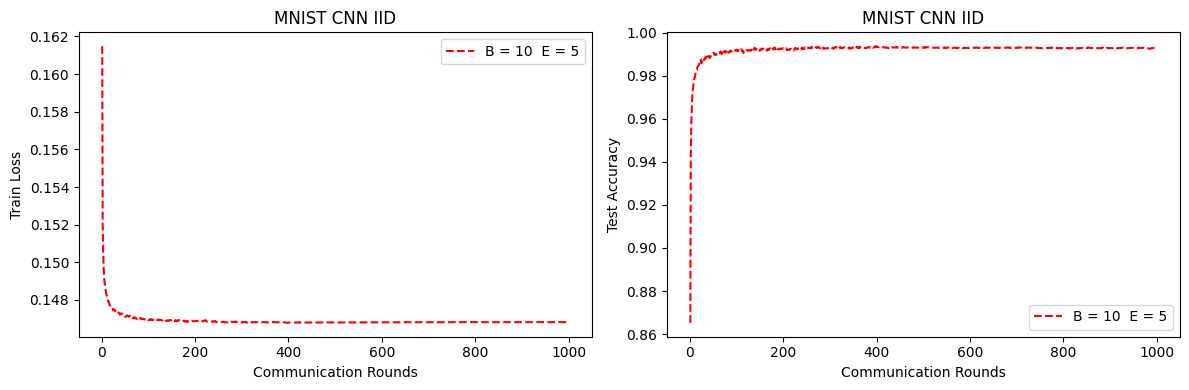

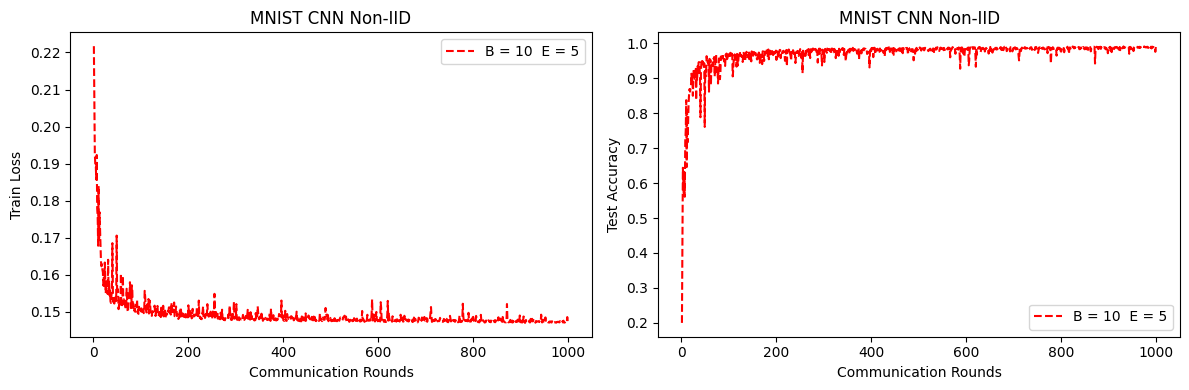

In [10]:
torch.save(global_model_IID, "FedAvg_IID")
torch.save(global_model_nonIID, "FedAvg_nonIID")

model_stats_IID = summary(global_model_IID, input_size=(1, 28, 28), verbose=2)
model_stats_nonIID = summary(global_model_nonIID, input_size=(1, 28, 28), verbose=2)

# global_model = torch.load('FedAvg_IID')
epochs_range = range(1, args.total_rounds + 1)

# Plot Global Training Loss for IID
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, round_losses_IID, color='red', linestyle="dashed", label="B = 10  E = 5")
plt.xlabel('Communication Rounds')
plt.ylabel('Train Loss')
plt.legend(loc='upper right')  # Move legend to bottom right
plt.title('MNIST CNN IID')

# Plot Global Validation Accuracy for IID
plt.subplot(1, 2, 2)
plt.plot(epochs_range, round_accuracies_IID, color='red', linestyle="dashed", label="B = 10  E = 5")
plt.xlabel('Communication Rounds')
plt.ylabel('Test Accuracy')
plt.legend(loc='lower right')  # Move legend to bottom right
plt.title('MNIST CNN IID')

plt.tight_layout()
plt.show()

# Plot Global Training Loss for nonIID
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, round_losses_nonIID, color='red', linestyle="dashed", label="B = 10  E = 5")
plt.xlabel('Communication Rounds')
plt.ylabel('Train Loss')
plt.legend(loc='upper right')  # Move legend to bottom right
plt.title('MNIST CNN Non-IID')

# Plot Global Validation Accuracy for nonIID
plt.subplot(1, 2, 2)
plt.plot(epochs_range, round_accuracies_nonIID, color='red', linestyle="dashed", label="B = 10  E = 5")
plt.xlabel('Communication Rounds')
plt.ylabel('Test Accuracy')
plt.legend(loc='lower right')  # Move legend to bottom right
plt.title('MNIST CNN Non-IID')

plt.tight_layout()
plt.show()